In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import requests
import os
from collections import Counter

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

tf.random.set_seed(17)

In [253]:
!rm -rf cousteau
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [254]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 589, done.
remote: Counting objects: 100% (589/589), done.
remote: Compressing objects: 100% (528/528), done.
remote: Total 589 (delta 96), reused 548 (delta 60), pack-reused 0
Receiving objects: 100% (589/589), 27.56 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  if label == "7_5":
    label = 0
  elif label == "7":
    label = 1
  elif label == '6':
    label = 2
  else: 
    label = 3
  labels.append(label)

In [256]:
Counter(labels).keys()

dict_keys([2, 1, 3, 0])

In [257]:
Counter(labels).values()

dict_values([89, 89, 60, 77])

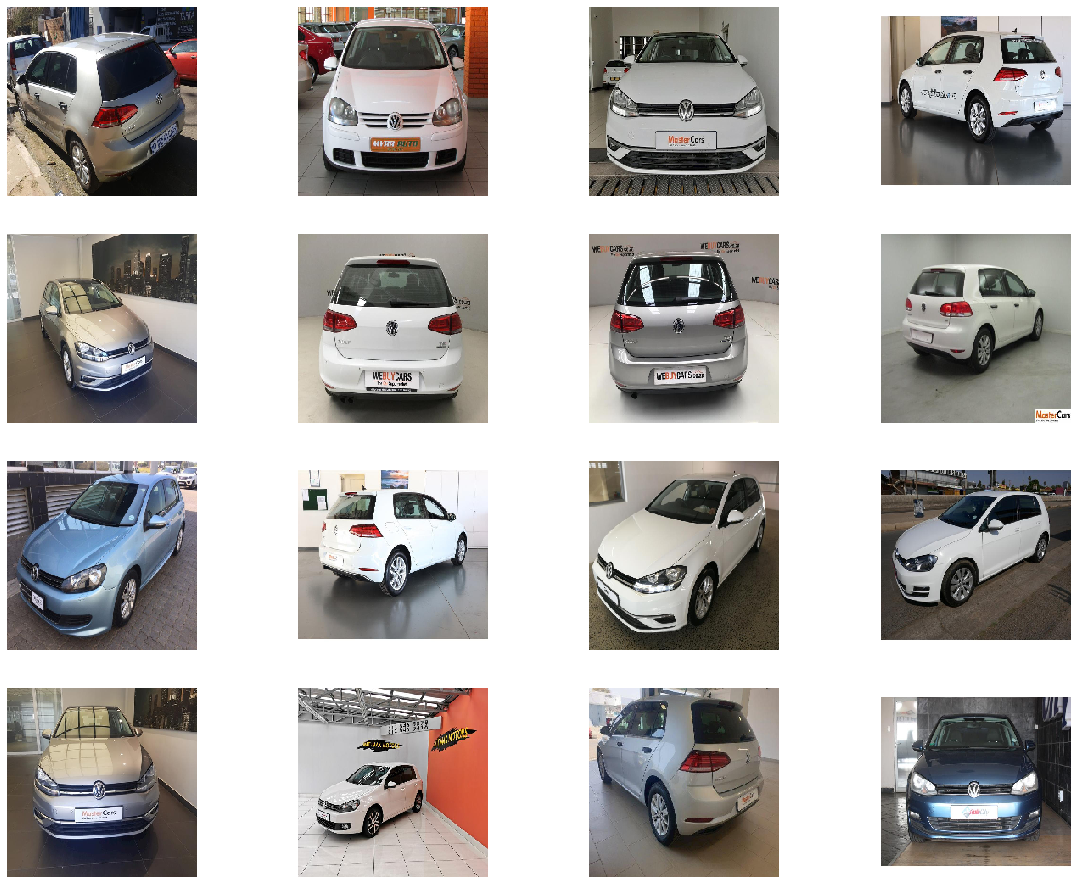

In [258]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

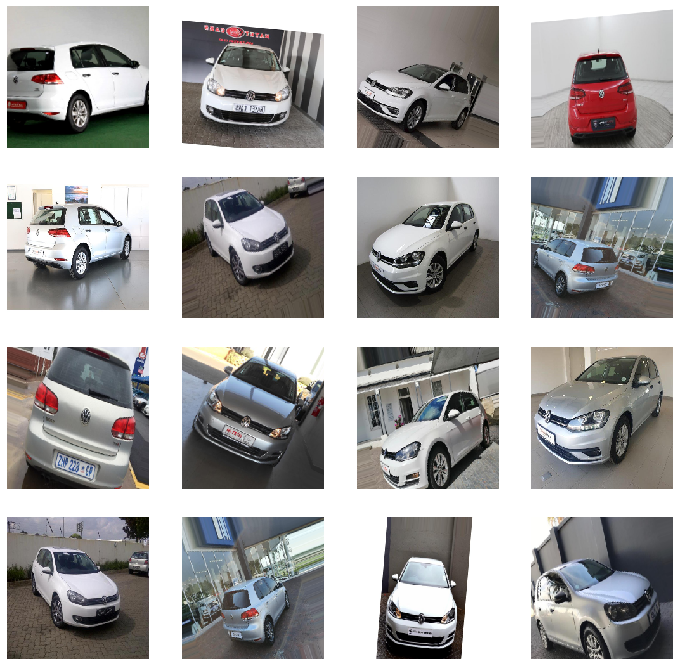

In [264]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labez = [[label] * REPLICATES for label in labels]

In [0]:
labelz = np.array([label for sublist in labez for label in sublist])

In [267]:
print('Image count (after transform): {}'.format(len(images)), '\n', 'Label count (after transform): {}'.format(len(labelz)))

Image count (after transform): 1260 
 Label count (after transform): 1260


In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labelz, test_size=0.2, random_state=13)

In [0]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# VGG w/ weights initialised from Imagenet

In [0]:
BATCH_SIZE=32
EPOCHS = 30
LEARNING_RATE = 5e-5

In [0]:
base_model_hold = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model = base_model_hold
base_model.trainable = True

In [275]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
def build_network(base, dropout_perc = 0.5, kernel_reg = 0.05):

  model = models.Sequential()

  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(kernel_reg)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(dropout_perc))
  model.add(layers.Dense(4, activation='softmax'))

  return model

In [0]:
vgg = build_network(base_model)

In [0]:
vgg.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizers.Adam(lr=LEARNING_RATE),
    metrics=['accuracy']
)

In [279]:
history = vgg.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.2
)

Train on 806 samples, validate on 202 samples
Epoch 1/30
806/806 [==============================] - 13s 16ms/sample - loss: 3.7246 - accuracy: 0.3102 - val_loss: 6.1471 - val_accuracy: 0.4010
Epoch 2/30
806/806 [==============================] - 12s 14ms/sample - loss: 3.0673 - accuracy: 0.4429 - val_loss: 4.7985 - val_accuracy: 0.3911
Epoch 3/30
806/806 [==============================] - 12s 14ms/sample - loss: 2.6645 - accuracy: 0.5645 - val_loss: 2.9860 - val_accuracy: 0.5743
Epoch 4/30
806/806 [==============================] - 12s 15ms/sample - loss: 2.3624 - accuracy: 0.6911 - val_loss: 2.6618 - val_accuracy: 0.6584
Epoch 5/30
806/806 [==============================] - 12s 15ms/sample - loss: 2.1245 - accuracy: 0.8077 - val_loss: 2.4718 - val_accuracy: 0.6782
Epoch 6/30
806/806 [==============================] - 12s 15ms/sample - loss: 1.9977 - accuracy: 0.8573 - val_loss: 2.0299 - val_accuracy: 0.8416
Epoch 7/30
806/806 [==============================] - 12s 15ms/sample - loss: 

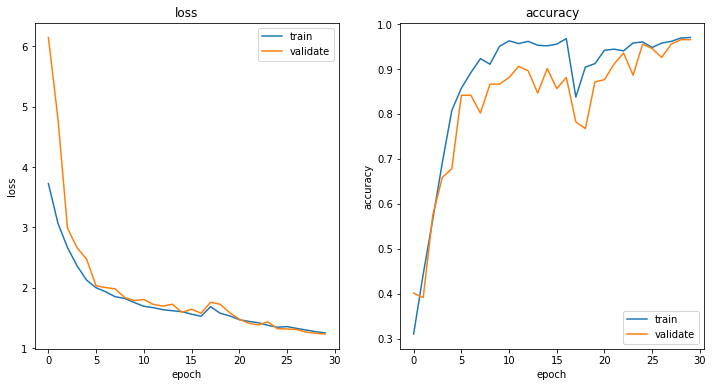

In [280]:
plot_history(history)

In [281]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 93.65% 
Test loss     = 1.251375


In [282]:
print(classification_report(y_test.argmax(axis=1), vgg.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        49
           1       0.99      0.90      0.94        81
           2       0.87      0.99      0.93        75
           3       1.00      0.87      0.93        47

    accuracy                           0.94       252
   macro avg       0.95      0.93      0.94       252
weighted avg       0.94      0.94      0.94       252



## All the data

In [0]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [0]:
EPOCHS = 30
LEARNING_RATE = 5e-5

In [0]:
base_model = base_model_hold
base_model.trainable = True
vgg_all = build_network(base_model, dropout_perc=0.5, kernel_reg=0.06)

In [0]:
vgg_all.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizers.Adam(lr=LEARNING_RATE),
    metrics=['accuracy']
)

In [287]:
history = vgg_all.fit(
    X, y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.2
)

Train on 1008 samples, validate on 252 samples
Epoch 1/30
1008/1008 [==============================] - 16s 16ms/sample - loss: 3.2310 - accuracy: 0.4861 - val_loss: 3.7176 - val_accuracy: 0.5476
Epoch 2/30
1008/1008 [==============================] - 15s 15ms/sample - loss: 2.3893 - accuracy: 0.8095 - val_loss: 2.2340 - val_accuracy: 0.8532
Epoch 3/30
1008/1008 [==============================] - 15s 15ms/sample - loss: 2.1572 - accuracy: 0.8790 - val_loss: 1.9595 - val_accuracy: 0.9603
Epoch 4/30
1008/1008 [==============================] - 15s 15ms/sample - loss: 1.9939 - accuracy: 0.9147 - val_loss: 1.8201 - val_accuracy: 0.9484
Epoch 5/30
1008/1008 [==============================] - 15s 15ms/sample - loss: 1.8658 - accuracy: 0.9315 - val_loss: 1.7395 - val_accuracy: 0.9563
Epoch 6/30
1008/1008 [==============================] - 15s 15ms/sample - loss: 1.7389 - accuracy: 0.9494 - val_loss: 1.6210 - val_accuracy: 0.9563
Epoch 7/30
1008/1008 [==============================] - 15s 15ms/

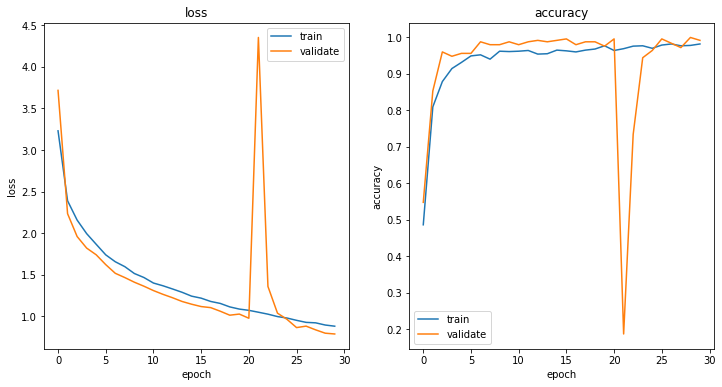

In [288]:
plot_history(history)

# Unseen data

## Helper functions

In [0]:
def store_image(img_url, class_type):

  filename = ''
  response = requests.get(img_url)

  if response.status_code == 200:
    directory = 'car-dataset/train/{}'.format(class_type)
    os.chdir(directory)
    filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)

    with open('{}.jpg'.format(filename), 'wb') as f:
      f.write(response.content)

    os.chdir('../../..')

  return directory + '/{}.jpg'.format(filename)

In [0]:
def classify(img_url, class_type, **trained_model):
  
  filename = store_image(img_url, class_type)
  img = image.load_img(filename, target_size=(224, 224))

  plt.imshow(np.squeeze(img).astype('uint8'))

  img = image.img_to_array(img)
  img = resnet.preprocess_input(img)
  img = np.expand_dims(img, axis=0)

  for name, model in trained_model.items(): 
    golf = model.predict_classes(img)
    if (golf == 0):
      golf = '7.5'
    elif (golf == 1):
      golf = '7'
    elif (golf == 2):#se:
      golf = '6'
    else: 
      golf = 5
    print('Classifier:', name)
    print('Golf model:', golf, ', proba:', model.predict_proba(img), '\n')

## Golf 5

Classifier: vgg_model
Golf model: 5 , proba: [[0.05179828 0.04725551 0.21224    0.6887062 ]] 

Classifier: vgg_all
Golf model: 5 , proba: [[0.02698282 0.03253122 0.03702969 0.9034563 ]] 



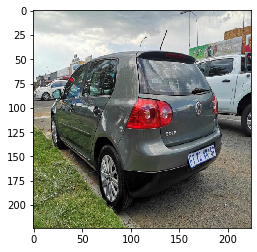

In [291]:
classify(
    'https://www.carmag.co.za/car-images/Gauteng/6091-648349_5/2007-Volkswagen-GOLF-5-GOLF-2.0-COMFORTLINE-5.jpeg',
    '5', vgg_model = vgg, vgg_all = vgg_all
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.02286647 0.04680934 0.14130221 0.78902197]] 



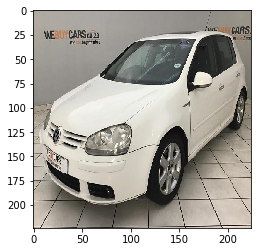

In [292]:
classify(
    'https://img.autotrader.co.za/5332243/Crop800x600',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.03005261 0.12130299 0.1619733  0.6866711 ]] 



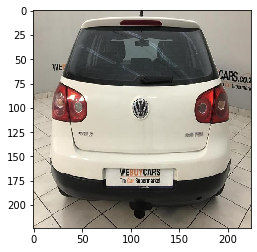

In [293]:
classify(
    'https://img.autotrader.co.za/5332244/Crop800x600',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.01300321 0.03590959 0.15109736 0.79998976]] 



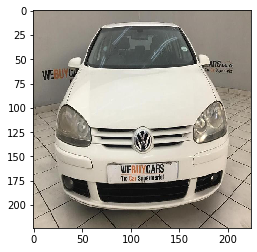

In [294]:
classify(
    'https://img.autotrader.co.za/5332246/Crop800x600',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 5 , proba: [[0.03368549 0.04523126 0.13888618 0.78219706]] 



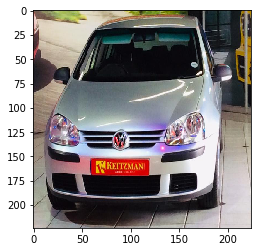

In [295]:
classify(
    'https://img.autotrader.co.za/5243443/Crop800x600',
    '5', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 7 , proba: [[0.06224887 0.5982574  0.10325928 0.23623444]] 



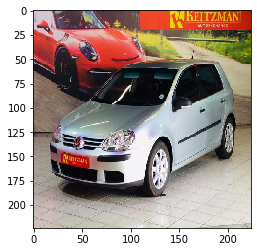

In [296]:
classify(
    'https://img.autotrader.co.za/5243442/Crop800x600',
    '5', vgg_model = vgg 
    )

## Golf 6

Classifier: vgg_model
Golf model: 6 , proba: [[0.01673766 0.0028903  0.95795995 0.0224121 ]] 



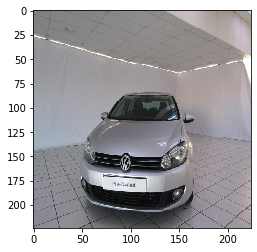

In [297]:
classify(
    'https://img.autotrader.co.za/3760195/Crop800x600',
    '6', vgg_model = vgg 
    )

Classifier: vgg_model
Golf model: 6 , proba: [[0.0509789  0.00283969 0.915299   0.03088241]] 



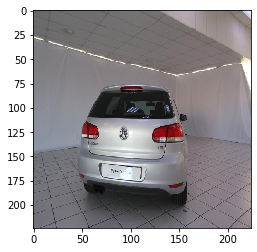

In [298]:
classify(
    'https://img.autotrader.co.za/3760198/Crop800x600',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.0897074  0.00659788 0.8546999  0.04899479]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.08234835 0.02433916 0.8703751  0.02293737]] 



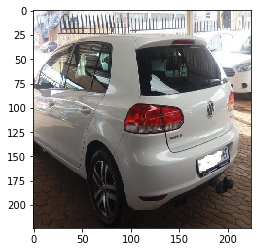

In [299]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_5.jpg?v=1868034972',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.08908839 0.00712101 0.876937   0.0268537 ]] 



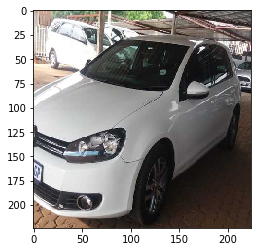

In [300]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351.jpg?v=1868034972',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.03180655 0.0430837  0.82028896 0.10482074]] 



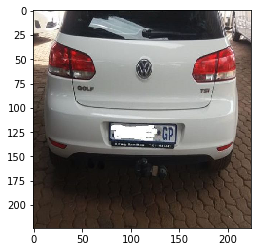

In [301]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_6.jpg?v=1868034972',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.06550991 0.07911643 0.79321814 0.0621555 ]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.07313674 0.4503294  0.43122306 0.0453108 ]] 



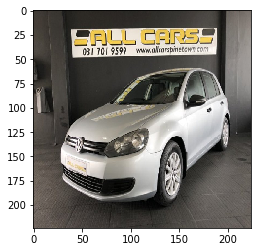

In [302]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964.jpg?v=125421204',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.01622255 0.0033015  0.95706993 0.02340599]] 



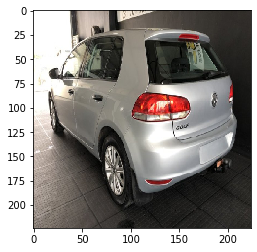

In [303]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964_3.jpg?v=125421204',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.02479696 0.00341553 0.9477972  0.02399028]] 



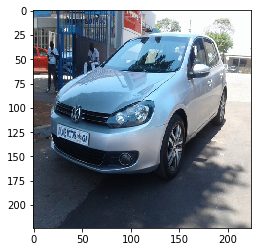

In [304]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.02570631 0.00165795 0.9530378  0.01959802]] 



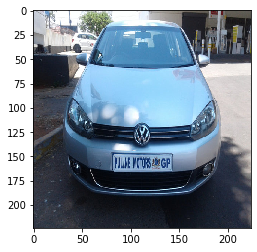

In [305]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_2.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00874664 0.00320231 0.96581006 0.02224104]] 



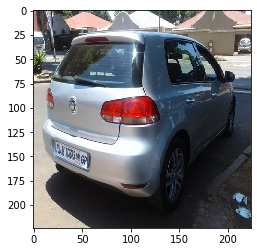

In [306]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_8.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.01931033 0.00234366 0.95787144 0.02047454]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.00776134 0.00543662 0.9846902  0.00211188]] 



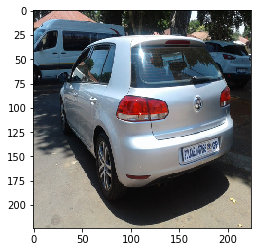

In [307]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_7.jpg?v=2265708515',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.02082174 0.007357   0.9306585  0.04116268]] 



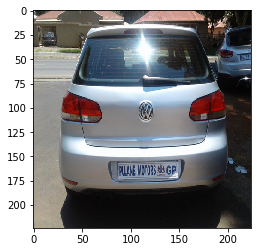

In [308]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_6.jpg?v=2265708515',
    '6', vgg_model = vgg
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.01237895 0.00189762 0.9561412  0.02958227]] 



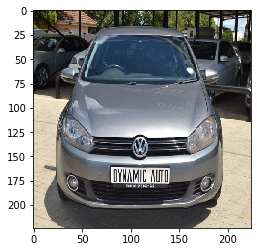

In [309]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5530306_2.jpg?v=4074465811',
    '6', vgg_model = vgg
)

## Golf 7


Classifier: vgg_model
Golf model: 7 , proba: [[0.04421611 0.9330836  0.00896493 0.01373529]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.01267526 0.9510898  0.00943916 0.02679582]] 



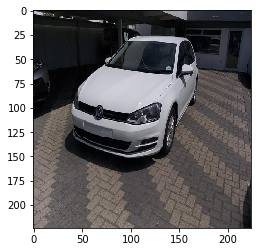

In [310]:
classify(
         'https://img.autotrader.co.za/5248234/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )


Classifier: vgg_model
Golf model: 7 , proba: [[0.13047759 0.6763881  0.13506459 0.05806972]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.04365414 0.9127111  0.02528029 0.01835457]] 



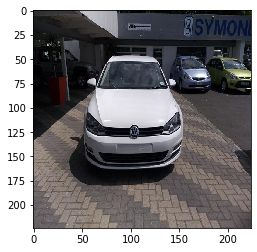

In [311]:
classify(
         'https://img.autotrader.co.za/5248233/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7 , proba: [[0.02784832 0.9514558  0.00547987 0.01521592]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.00514289 0.9764872  0.00728102 0.01108897]] 



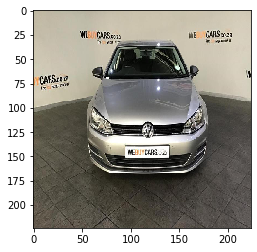

In [312]:
classify(
         'https://img.autotrader.co.za/5369150/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7 , proba: [[0.12818693 0.84113353 0.01371947 0.01696003]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.0133981  0.95553094 0.00884223 0.02222873]] 



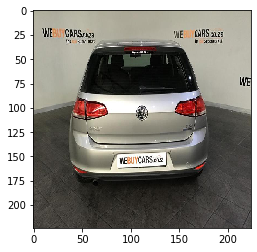

In [313]:
classify(
         'https://img.autotrader.co.za/5369148/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7 , proba: [[0.04212247 0.89652    0.03682698 0.02453048]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.01023852 0.9591524  0.01568803 0.01492093]] 



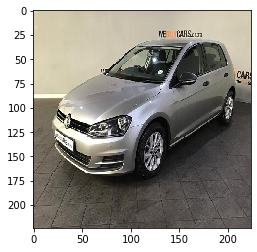

In [314]:
classify(
         'https://img.autotrader.co.za/5369147/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7 , proba: [[0.02757924 0.95817065 0.00629939 0.00795069]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.01126417 0.96326435 0.01205598 0.01341545]] 



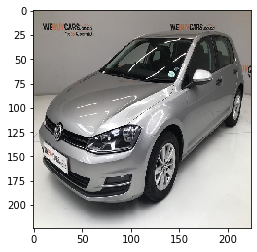

In [315]:
classify(
         'https://img.autotrader.co.za/5369468/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7 , proba: [[0.02390676 0.96173537 0.00534521 0.00901269]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.00196449 0.99124897 0.0026105  0.00417597]] 



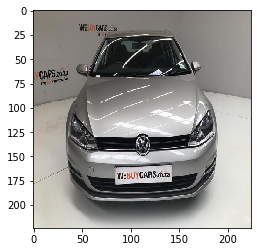

In [316]:
classify(
         'https://img.autotrader.co.za/5369471/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7 , proba: [[0.18217275 0.66490513 0.11350229 0.03941989]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.04215562 0.9104121  0.02557543 0.0218569 ]] 



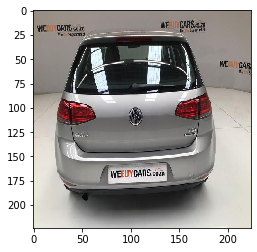

In [317]:
classify(
         'https://img.autotrader.co.za/5369469/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 6 , proba: [[0.11853211 0.1829585  0.6096427  0.08886671]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.0403621  0.7608579  0.15934226 0.03943778]] 



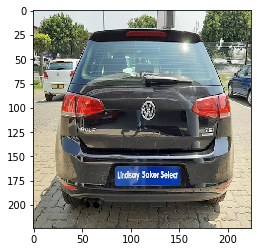

In [318]:
classify(
    'https://img.autotrader.co.za/5353441/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.10778677 0.8391281  0.03355672 0.01952853]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.02613954 0.93968767 0.01477539 0.01939735]] 



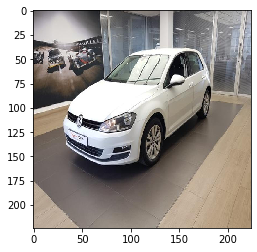

In [319]:
classify(
    'https://img.autotrader.co.za/5375620/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.04732418 0.9195471  0.00833662 0.02479203]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.00656305 0.981961   0.00588623 0.0055897 ]] 



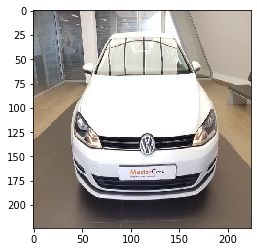

In [320]:
classify(
    'https://img.autotrader.co.za/5375621/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7 , proba: [[0.09381194 0.7661777  0.0587499  0.08126041]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.01386254 0.9567319  0.014915   0.01449061]] 



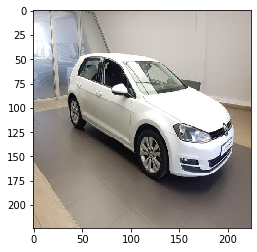

In [321]:
classify(
    'https://img.autotrader.co.za/5375622/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.7092523  0.12803058 0.14716499 0.01555214]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.8513125  0.07423212 0.06263503 0.0118203 ]] 



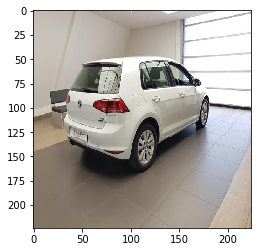

In [322]:
classify(
    'https://img.autotrader.co.za/5375623/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.5465549  0.09840522 0.31576633 0.03927355]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.8296338  0.07091544 0.08872923 0.01072161]] 



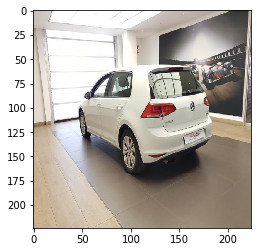

In [323]:
classify(
    'https://img.autotrader.co.za/5375624/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

## Golf 7.5

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.83900124 0.07445382 0.06757608 0.01896877]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.7842689  0.15277347 0.02995302 0.03300462]] 



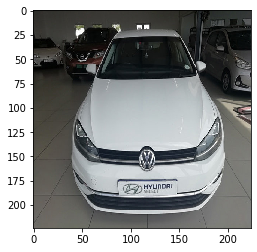

In [324]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_3.jpg?v=317154964',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.8842419  0.00901129 0.09227179 0.01447503]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.9665433  0.0060345  0.011809   0.01561326]] 



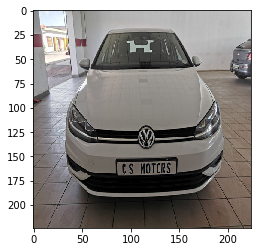

In [325]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_2.jpg?v=158700226',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.9571026  0.01235451 0.02381619 0.00672667]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.97661155 0.00735677 0.00845757 0.00757405]] 



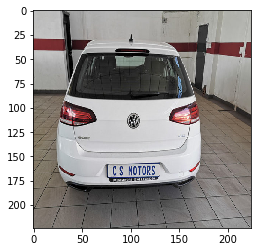

In [326]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_7.jpg?v=158700226',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9036914e-01 2.5277818e-03 6.3426853e-03 7.6035497e-04]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.98560333 0.00319875 0.00549719 0.00570068]] 



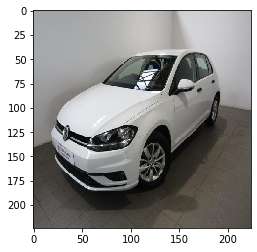

In [327]:
classify(
    'https://img.autotrader.co.za/5361261/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.8762721  0.02577197 0.08946592 0.00848993]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.94161636 0.02341701 0.02113006 0.01383652]] 



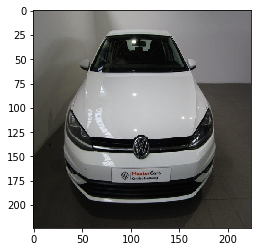

In [328]:
classify(
    'https://img.autotrader.co.za/5361262/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.96682054 0.00457138 0.0250263  0.00358173]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.98519474 0.00460725 0.00493811 0.00525992]] 



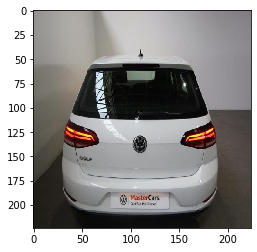

In [329]:
classify(
    'https://img.autotrader.co.za/5361267/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.8961113  0.03811906 0.05739267 0.00837699]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.95402646 0.02418383 0.01253325 0.00925641]] 



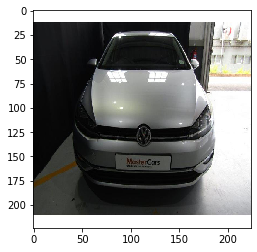

In [330]:
classify(
    'https://img.autotrader.co.za/5149727/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.63885486 0.12091903 0.20972429 0.03050174]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.6024029  0.3062245  0.04857108 0.04280156]] 



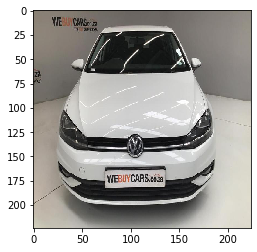

In [331]:
classify(
    'https://img.autotrader.co.za/5314452/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.8412944  0.02154289 0.12350666 0.01365599]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.9321417  0.0168326  0.02862961 0.02239617]] 



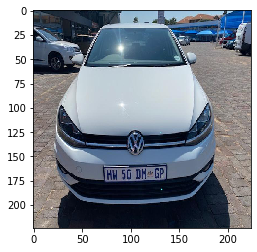

In [332]:
classify(
    'https://img.autotrader.co.za/5375761/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.813915   0.01765564 0.15133375 0.0170955 ]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.9339765  0.01140636 0.02854134 0.02607581]] 



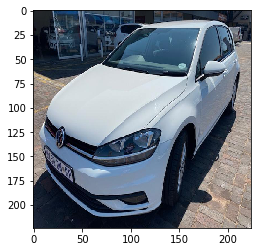

In [333]:
classify(
    'https://img.autotrader.co.za/5375760/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.9409342  0.00578674 0.04479976 0.00847932]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.97432125 0.00413841 0.01282289 0.00871747]] 



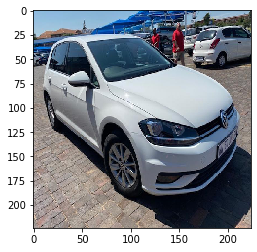

In [334]:
classify(
    'https://img.autotrader.co.za/5375763/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.89164126 0.03612877 0.06351896 0.00871109]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.95981014 0.01350042 0.01639923 0.01029023]] 



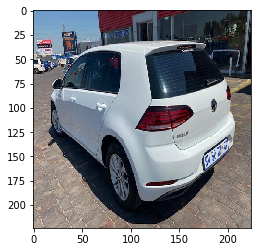

In [335]:
classify(
    'https://img.autotrader.co.za/5375762/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

In [0]:
# 1. Change classify function to accept multiple models
# 2. Build simple network to count side/front/rear shots of each class
# 3. Investigate network ensemblefrom sklearn.metrics import classification_report